In [2]:
import sys

sys.path.append("..")
from flame_analysis_model import *
from mpi4py import MPI
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sympy
from pysr import PySRRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\juliacall\__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [7]:


comm = MPI.COMM_WORLD
rank = comm.rank

# Scalar names
scalars = [
    'H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
    'curvature', 'stretch_rate', 'disp_speed_density_weighted',
    'abs_flame_prop_vel_normal', 'flow_velocity_normal',
    'flow_velocity_tangential', 'tangential_strain_rate',
    'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
    'vorticity'
]
folder_name = "old_phi0.40_h100"
# Geometry / reference file (constant)
gname = f"./data/{folder_name}/po_premix0.f00001"

# List to collect flame-front slices from all timesteps
front_list = []
timestep_start = 122
timestep_end = 123
var_name = "disp_speed_density_weighted"  #"disp_speed_density_weighted" #"T"
features = ["curvature", "stretch_rate", "total_strain_rate"]

for timestep in range(timestep_start, timestep_end):
    # Adjust zero padding to match your actual filenames
    print(f"Time step is now {timestep}")
    fname = f"./data/{folder_name}/po_premix0.f{timestep:05d}"

    ds = SEMDataset(
        fname,
        comm=comm,
        gname=gname,
        scalar_names=scalars
    )

    df_full = ds.create_dataframe(
        compute_vel_jacobian=False,
        compute_vel_hessian=False,
        compute_reaction_rates=False,
        cantera_inputs=["BurkeH2.yaml", None, 0.5, 300, 5e05]
    )
    print(f"Timestep {timestep}: points before filtering = {len(df_full)}")
    Tmin = df_full["T"].min()
    Tmax = df_full["T"].max()
    df_full["Tnorm"] = (df_full["T"] - Tmin) / (Tmax - Tmin)
    df_front = df_full[(df_full["Tnorm"] > 0.75) & (df_full["Tnorm"] < 0.77)]
    print(f"Timestep {timestep}: points after filtering = {len(df_front)}")
    # Keep only what we need for DMD
    df = df_front[[var_name] + features].copy()
    df.loc[:, "timestep"] = timestep

    front_list.append(df)
    del df_full

# Concatenate all timesteps into a single DataFrame
front_all = pd.concat(front_list, ignore_index=True)
del front_list

print(front_all.shape)
print(front_all.head())
print(front_all['timestep'].unique())

#Prepare data for PySR
X = front_all[features].copy()
y = front_all[var_name].to_numpy()
# PySR expects numpy or pandas; DataFrame is convenient
print("X_df shape:", X.shape)
print("y_array shape:", y.shape)



Time step is now 122
2025-11-23 10:18:46,467 - Mesh - INFO - Initializing empty Mesh object.
2025-11-23 10:18:46,468 - Field - INFO - Initializing empty Field object
2025-11-23 10:18:46,468 - pynekread - INFO - Reading file: ./data/old_phi0.40_h100/po_premix0.f00001
2025-11-23 10:18:46,492 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-11-23 10:18:46,493 - Mesh - INFO - Initializing common attributes.
2025-11-23 10:18:46,493 - Mesh - INFO - Getting vertices
2025-11-23 10:18:46,499 - Mesh - INFO - Getting edge centers
2025-11-23 10:18:46,563 - Mesh - INFO - Facet centers not available for 2D
2025-11-23 10:18:46,564 - Mesh - INFO - Mesh object initialized.
2025-11-23 10:18:46,564 - Mesh - INFO - Mesh data is of type: float64
2025-11-23 10:18:46,564 - Mesh - INFO - Elapsed time: 0.0726204999955371s
2025-11-23 10:18:46,565 - pynekread - INFO - Reading field data
2025-11-23 10:18:46,565 - pynekread - INFO - Overwriting fld object
2025-11-23 10:18:46,857 - pynekread - INF

In [8]:
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X, y)
gpr.score(X, y)

0.8488857601893501

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


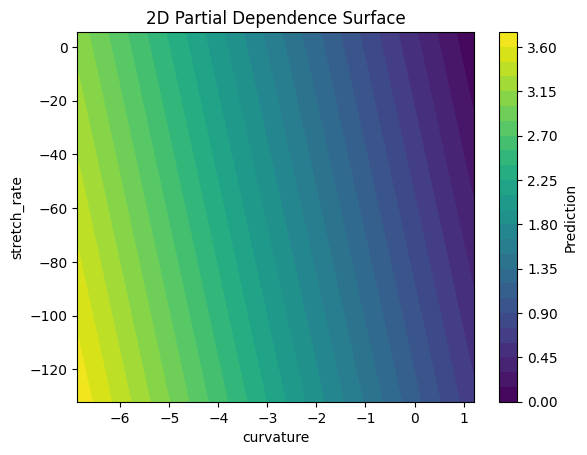

In [11]:
import numpy as np
import matplotlib.pyplot as plt

f1, f2 = "curvature", "stretch_rate"
i1, i2 = X.columns.get_loc(f1), X.columns.get_loc(f2)

x1 = np.linspace(X[f1].quantile(0.01), X[f1].quantile(0.99), 50)
x2 = np.linspace(X[f2].quantile(0.01), X[f2].quantile(0.99), 50)

xx1, xx2 = np.meshgrid(x1, x2)

# Base point
x0 = X.median().to_numpy()

grid = np.tile(x0, (xx1.size, 1))
grid[:, i1] = xx1.ravel()
grid[:, i2] = xx2.ravel()

yy = gpr.predict(grid).reshape(xx1.shape)

plt.figure()
plt.contourf(xx1, xx2, yy, levels=30)
plt.xlabel(f1)
plt.ylabel(f2)
plt.colorbar(label="Prediction")
plt.title("2D Partial Dependence Surface")
plt.show()


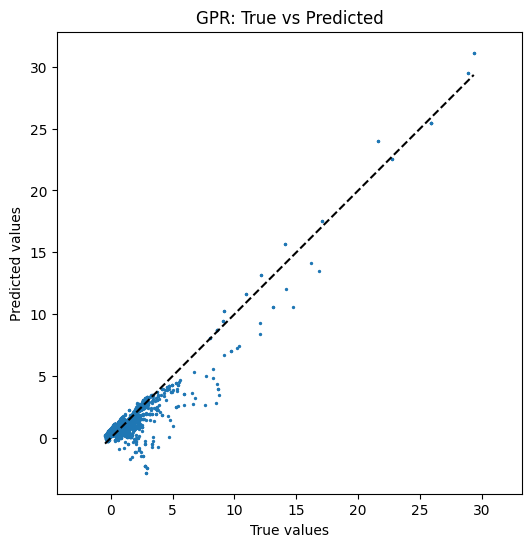

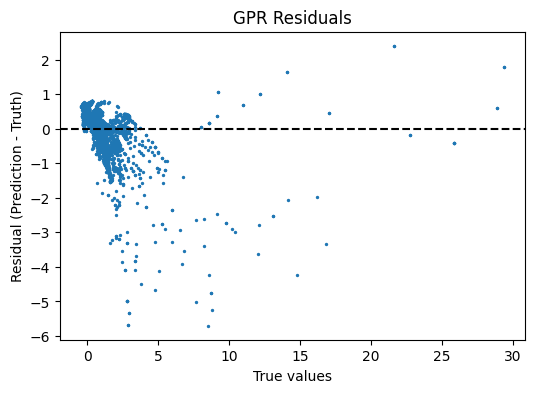

In [14]:

y_pred = gpr.predict(X)

plt.figure(figsize=(6,6))
plt.scatter(y, y_pred, s=2)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("GPR: True vs Predicted")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.axis("equal")
plt.show()

residuals = y_pred - y

plt.figure(figsize=(6,4))
plt.scatter(y, residuals, s=2)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("True values")
plt.ylabel("Residual (Prediction - Truth)")
plt.title("GPR Residuals")
plt.show()


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


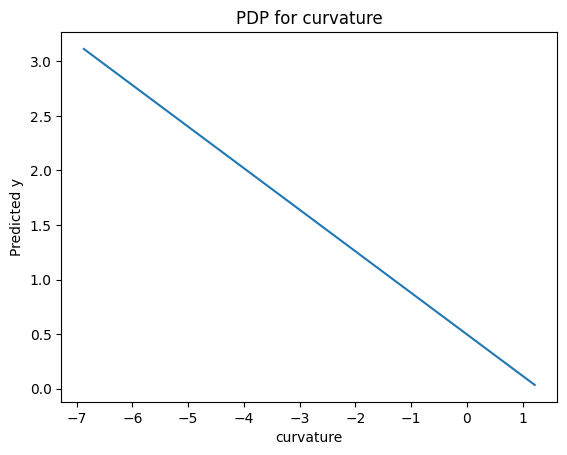

In [17]:
feature = "curvature"
i = X.columns.get_loc(feature)

# Grid of values
x_range = np.linspace(X[feature].quantile(0.01),
                      X[feature].quantile(0.99), 200)

# Base point: median of all data
x0 = X.median().to_numpy()

# Create grid for prediction
X_grid = np.tile(x0, (200, 1))
X_grid[:, i] = x_range

y_grid = gpr.predict(X_grid)

plt.figure()
plt.plot(x_range, y_grid)
plt.xlabel(feature)
plt.ylabel("Predicted y")
plt.title(f"PDP for {feature}")
plt.show()
